#LightFM Pipeline

왓책피디아 추천시스템을 위한 LightFM 모델을 적용한 ipynb입니다.

$$Paper Review --> Preparation 1/2 -> Dataset Building -> Hyperparameter Tuning -> Predict$$

순으로 구성되어 있으며, 본 ipynb에서 나온 Predict 결과를 기반으로 csv가 저장되어 웹에서 그 결과가 구현됩니다.


#Paper Review

본 Paper Review는 "Metadata Embeddings for User and Item Cold-start Recommendations"(2015)를 기반으로 합니다.

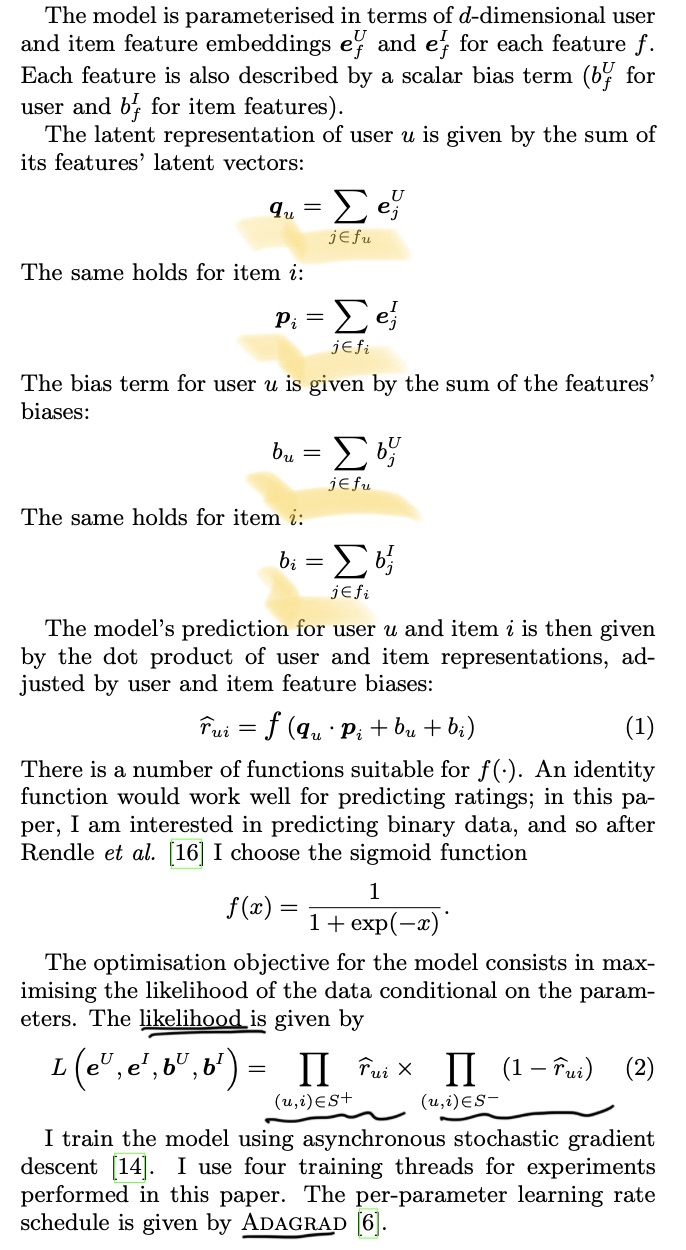

1) Summary

본 논문 이전까지는 Cold-Start Problem, 즉 User 평가 데이터가 전무한 상황에서의 예측 능력이 현저히 떨어지는 것에 대한 효과적인 솔루션이 비교적 부족한 실정이었다. Sparse Dataset에 대한 Matrix Factorization들이 Latent Variable을 추정하기 어렵기 때문이다.

따라서 Metadata, 즉 Content-based를 통해 Item이나 User를 표현한다. 하지만 Transfer Learning은 불가능하기에 결과적으로 많은 양의 데이터를 추천시스템 로직으로 구현해내기에는 성능적으로 제한사항이 많다.

따라서 LightFM이라는 Hybrid 모델은 Content based model과 Collaborative Filtering의 장점을 결합한 모델이다. Training 시에 User/Item Feature를 모두 활용하며, LightFM에서 생성된 Embedding vector(추후 모델에서 활용하는 n_components)가 Feature의 중요한 정보를 포함하고 이는 tag 추천과 같은 일에서 중요하게 사용될 수 있다.

2) Model

모델 구성 자체는 타 모델 대비 심플하게 구성되어 있으며, Item/User Feature를 동시에 활용하는 것이 특징적이라고 할 수 있다. 

User u에 대한 잠재 벡터는 그 User의 Features의 잠재 벡터들의 합으로 구성되며, Item 역시 같은 방법으로 계산한다. Bias 항 또한 아래와 같이 계산된다.

$q_u = \sum_{j \in f_u}e_j^U$, 
$p_i = \sum_{j \in f_i}e_j^I$, 
$b_u = \sum_{j \in f_u}b_j^U$,
$b_i = \sum_{j \in f_i}b_j^I$

User i와 item i에 대한 모델의 예측값은, User i와 item i의 Representation(Latent Vector)의 내적으로 이루어진다. 잠재 벡터의 경우, d-차원 Embedding vector(n_components)에 의해 Matrix Factorization을 기반으로 계산된다. 이때 $S^+$는 Positive Interaction, $S^-$는 Negative Interaction을 가리킨다.


$$\hat{r}_{ui} = sigmoid(q_u \odot p_i + b_u + b_i)$$


이에 대한 Loss Function에 대한 Optimization은 다음과 같이 진행된다.

$$L(e^U, e^I, b^U, b^I) = \prod_{(u,i) \in S^+} \hat{r}_{ui} \times \prod_{(u,i) \in S^-} (1- \hat{r}_{ui})$$

여담으로, 실제 모델에서는 'Warp' Loss를 활용하는데, 이는 단순히 Positive/Negative Interaction만 계산하는 것이 아니라, Negative Feedback 위반 사례(부정적인 평가에 대하여 잘못 예측한 결과)에 대하여 초반 Sampling 후의 Gradient Update에는 큰 Weight를 부여하고, 나중에 충분히 Sampling이 된 후의 Gradient Update에는 작은 가중치를 부여하는 방식으로 이루어져 더 정확한 직관을 제공한다.


#Preparation_1

LightFM Library 설치와 Crawling해둔 왓책피디아 Dataset을 준비합니다. 또한, 데이터를 pandas로 불러오고 결측치나 index와 같은 개괄적인 dataframe을 확인합니다. 왓책피디아 취지에 맞도록 index의 범위를 설정하고, 변환합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Install
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 4.9 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp38-cp38-linux_x86_64.whl size=746176 sha256=b4dd93c531f21241c5a42337f14df7d2d38e4a71a0b82998b001b25652bbaf7b
  Stored in directory: /root/.cache/pip/wheels/ec/bb/51/9c487d021c1373b691d13cadca0b65b6852627b1f3f43550fa
Successfully built lightfm


In [ ]:
from lightfm import LightFM 
from scipy import sparse #Sparse Matrix를 만들기 위한 Library

import numpy as np
import pandas as pd

In [ ]:
df=pd.read_csv('/content/drive/Shareddrives/2022-2 KUBIG 추천시스템/2팀/6주차/도서 추천시스템/User_final.csv')
df=df.replace(np.NaN, 0.0)

In [ ]:
df.head()

,Unnamed: 0,제목,이동진 평론가,E열표,석미인,Hana,성유,정선주,134340,성빵,...,언블,뚱딸,김도희,Tae Young Heo,JungChan Yoon,Candace Jiwon Yoon,최혜림,MK LOVE SK,다솜,SBee
0,0,물고기는 존재하지 않는다,5.0,4.5,4.5,4.0,5.0,5.0,3.5,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,예술가들의 이상심리,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,어느 독일인 이야기,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,세상에서 가장 널리 알려진 미신의 숫자 13,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,미신의 연대기,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Columns: 8631 entries, Unnamed: 0 to SBee
dtypes: float64(8629), int64(1), object(1)
memory usage: 161.6+ MB


In [ ]:
item=pd.read_csv('/content/drive/Shareddrives/2022-2 KUBIG 추천시스템/2팀/7주차/movie+book - movie+book.csv')

In [ ]:
item.head()

,Unnamed: 0,제목,연도,카테고리,내용
0,0,물방울을 그리는 남자*,2020,다큐멘터리,50년간 묵묵히 '물방울'만을 그리며?물방울 작가로 사랑받은 화가 김창열. 침묵과 ...
1,1,2차 송환*,2022,다큐멘터리,"""한국전쟁은 아직 끝나지 않았다!""?\n\n현재까지 남과 북은 정치 공작원들을 상호..."
2,2,달이 지는 밤*,2020,모험,중년의 여인이 무주 시외버스 터미널에서 내린다. 그녀는 마을길을 지나 숲으로 들어간...
3,3,썬더버드*,2021,범죄/액션,돈이 미치게 필요한 태균\n돈이 든 자동차를 잃어버린 태민\n돈은 중요하지 않은 미...
4,4,기기묘묘*,2022,공포/액션/스릴러,"땅을 둘러 싼 이웃들의 다툼,?엄마와 딸의 기이한 관계,?낙향한 청년과 괴인의 기묘..."


In [ ]:
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2454 non-null   int64 
 1   제목          2454 non-null   object
 2   연도          2454 non-null   int64 
 3   카테고리        2454 non-null   object
 4   내용          2454 non-null   object
dtypes: int64(2), object(3)
memory usage: 96.0+ KB


In [ ]:
item[item['카테고리'].isnull()] #세부 결측치 확인

,Unnamed: 0,제목,연도,카테고리,내용


In [ ]:
for i in range(2243,2454):
  item['Unnamed: 0'][i]=i
#index가 겹쳐서 data iteratable이 제대로 동작하지 않는 현상이 발생해서, 2243~2454의 범위로 book index 수정

#Preparation_2

LightFM Dataset을 만들기 위해 iteratable한 tuple로 dataset 내용을 변환합니다. Iterable Data 형태(*Pytorch DataLoader와 유사)로 변경하여 Dataset 라이브러리에 적용할 수 있도록 합니다.

user dataframe의 경우, (이름, movie_id, 평가점수)

item feature dataframe의 경우, (item_id, [제목, 연도, 카테고리, 내용])

형식으로 tuple을 만듭니다.

In [ ]:
rating_source=[] #(user_name, movie_id #숫자로 들어가야 해서 1부터 2453까지 int 형식의 id가 들어감, 평가점수)
user_id=list(df.columns)[2:]
for i in range(df.shape[0]):
  for j in user_id:
    if df[j][i]!=0:
      a=(j, df['Unnamed: 0'][i],df[j][i])
      rating_source.append(a)

In [ ]:
rating_source[:5]

[('이동진 평론가', 0, 5.0),
 ('E열표', 0, 4.5),
 ('석미인', 0, 4.5),
 ('Hana', 0, 4.0),
 ('성유', 0, 5.0)]

In [ ]:
from lightfm.data import Dataset
item=item[[	'Unnamed: 0'	,'제목'	,'연도'	,'카테고리'	,'내용']] #user tuple 만들 때와 비슷하게 진행됩니다
item_features_source=[(item['Unnamed: 0'][i], [item['제목'][i],item['연도'][i],item['카테고리'][i],item['내용'][i]]) for i in range(item.shape[0])]

In [ ]:
len(item_features_source)

2454

#Dataset Building

LightFM Model에 적용하기 위하여 Dataset을 알맞은 형태로 변환해줍니다. fit method에 각각 user과 item이 겹치는 것이 없도록 하여 값을 넣어주고, item_feature 역시 해당하는 값들을 flatten하여 넣어줍니다.

이후, build_interactions를 통해 

interactions--> (movie_id, user_id) 형태의 sparse matrix, 

weights--> ratings

build_item_features --> item_features dataset으로 각각 변환하여 줍니다.

In [ ]:
dataset=Dataset()
dataset.fit(users=np.unique(user_id), 
            items=item['Unnamed: 0'].unique(),item_features=item[item.columns[1:]].values.flatten())
#(user id 고윳값, item 고윳값 _ 이때 들어가는 id은 다 0,1,2와 같이 표시되어 있습니다. , item_features의 경우 원래 [a,[b,c,d]]처럼 되어 있는데 이를 flatten해서 []로 하여 값 전달)

In [ ]:
interactions, weights = dataset.build_interactions(rating_source) #interaction dataset을 생성해줍니다. interaction은 user_id와 movie_id를 이어주는 dataset입니다. weight는 해당 가중치입니다.
item_features=dataset.build_item_features(item_features_source) #item feature source 만들어준 tuple을 바탕으로 item feature를 만들어줍니다.

#Hyperparameter Tuning

learning_rate, n_components를 조절해보면서 hyperparameter tuning 작업을 진행합니다. 

no_components는 모델 속에서 feature들에 대한 latent variable의 차원을 정의해줍니다. no_components가 너무 커지면 overfitting 및 학습 자체가 잘 안될 수도 있어서 다양한 experiment가 필요합니다.


우선 auc_score method를 통해 AUC를 계산하는 것을 기반으로 evaluation이 진행됩니다. 여기에서 Loss는 known ratings와 user의 prediction에 대한 discrepancy(대개 L2 Loss)로 측정됩니다.
*알고 있는 rating들에 대한 예측을 진행하고, 그 rating에 대한 차이를 기반으로 AUC Loss가 정해집니다. 

이외에 k-OS Training 방식과 같은 학습을 통하여 performance를 높여볼 수 있습니다.

본 Hyperparameter Tuning에서는 

In [ ]:
from lightfm.evaluation import auc_score

learning_rate=[1e-2, 5e-3, 1e-3]
n_components=[80,60,20]
epoch=10
auc=0.0

for lr in learning_rate:
  for n in n_components:
      model = LightFM(no_components= n,learning_schedule='adagrad',learning_rate=lr, loss='warp') 
      model.fit(interactions=interactions,item_features=item_features,sample_weight=weights,epochs=epoch) 
      train_auc = auc_score(model,interactions,item_features=item_features).mean() 
      if train_auc>auc: 
        auc=train_auc
        best_param=(lr, n) 
        print(auc, best_param)

0.74382305 (0.01, 80)


In [ ]:
from lightfm.evaluation import auc_score

learning_rate=[1e-2, 5e-3, 1e-3]
n_components=[100,90,80]
epoch=10
auc=0.0

for lr in learning_rate:
  for n in n_components:
      model = LightFM(no_components= n,learning_schedule='adagrad',learning_rate=lr, loss='warp') 
      model.fit(interactions=interactions,item_features=item_features,sample_weight=weights,epochs=epoch) 
      train_auc = auc_score(model,interactions,item_features=item_features).mean() 
      if train_auc>auc:
        auc=train_auc
        best_param=(lr, n) 
        print(auc, best_param)

0.7515208 (0.01, 100)
0.75508016 (0.01, 90)


In [ ]:
from lightfm.evaluation import auc_score

learning_rate=[1e-2, 5e-2, 1e-3]
n_components=[100,90,80]
epoch=20
auc=0.0

for lr in learning_rate:
  for n in n_components:
      model = LightFM(no_components= n,learning_schedule='adagrad',learning_rate=lr, loss='warp') #optimizer = 'adagrad', loss='warp' / 'warp' loss가 optimizer계 adam과 같은 일반적으로 널리 쓰이는 loss
      model.fit(interactions=interactions,item_features=item_features,sample_weight=weights,epochs=epoch) #dataset class에서 만들어준 feature들을 넣어주고 epoch를 지정해줍니다.
      train_auc = auc_score(model,interactions,item_features=item_features).mean() #auc_score의 mean을 auc score
      if train_auc>auc: #기존 auc보다 더 높은 auc값이 나올 경우 Hyperparameter 저장
        auc=train_auc
        best_param=(lr, n)
        print(auc, best_param)

0.80218035 (0.01, 100)
0.9945072 (0.05, 100)


In [ ]:
model = LightFM(no_components= best_param[1],learning_schedule='adagrad',learning_rate=best_param[0], loss='warp') #해당 hyperparameter로 재 학습
model.fit(interactions=interactions,item_features=item_features,sample_weight=weights,epochs=epoch)

# Predict

결과를 보여주기 위해서 우선 id와 실제 이름을 mapping해주는 dictionary를 만들어줍니다.
(item/user dictionary 모두)

그 다음 prediction을 진행한 다음, 추천되는 상위 10개에 대해 그 제목을 출력해주는 함수를 제작 및 show해줍니다.

In [ ]:
def create_item_dict(df, id='Unnamed: 0', title='제목'): #{'0': '영화 이름1', '1':'영화이름2' ...}
  item_dict={}
  for i in range(df.shape[0]):
    item_dict[(df.loc[i,id])]=df.loc[i,title]
  return item_dict

In [ ]:
item_dict=create_item_dict(df)

In [ ]:
def create_user_dict(interactions): #{'0': '이동진 평론가', '1':'홍길동' ...}

    user_id=list(interactions.columns[2:])
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[counter] = i
        counter += 1
    return user_dict

user_dict=create_user_dict(df)

In [ ]:
def predict_book(df,model, user_id,user_dict,item_dict):
  scores=pd.Series(model.predict(user_id, (np.arange(0, 210))), index=[x for x in range(0, 210)]) #book 중에서만 추천 예측, book이 걸쳐있는 인덱스에서만 id 추출
  scores = pd.Series(scores.sort_values(ascending=False).index) #내림차순으로 book prediction 정렬 및 book id 표시
  name=user_dict[user_id]
  rating=df[name]
  rating_index=[]
  recommend=[]
  for i in range(df.shape[0]): #평점이 0보다 높다는 것은 평가를 했다는 뜻, 평점이 0이상인 건에 대해서는 제외하고 prediction을 보여준다
    if rating[i]>0:
      rating_index.append(i) 
  final=[x for x in list(scores.values) if x not in rating_index] #평점이 0이상인 prediction을 제외하고 나머지만 showing
  for u in final[:4]: #상위 n개에 대하여 print
    recommend.append(item_dict[u])
  return recommend 
  

predict_book(df,model, 1,user_dict,item_dict) #본 코드는 1번 이용자에 대하여 predict 진행

['박시백의 조선왕조실록', '프로젝트 헤일메리', '노마드랜드', '휴먼카인드']

In [ ]:
final=pd.DataFrame(columns=df.columns[2:],index=[0])
print(len(user_dict))
for i in range(8629):
  recommend=predict_book(df,model,i,user_dict, item_dict)
  final[user_dict[i]][0]=recommend

final.to_csv('/content/drive/MyDrive/final.csv')

8629


In [ ]:
book='미신 사전'
idx=item[(item['제목']==book)].index.values[0]
print(idx)

2250
